# EOF Analysis of AR days

* Multivariate EOF analysis of H, U and V

In [1]:
# Import Python modules
import os, sys
from pathlib import Path
import numpy as np
import numpy.ma as ma
import pandas as  pd
import xarray as xr
from sklearn.cluster import KMeans
# matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib.colors import ListedColormap
from matplotlib import rcParams
import matplotlib.ticker as mticker
# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean

from IPython.display import Image, display

# Path to modules
sys.path.append('../modules')

# Import my modules
from plotter import draw_basemap
from timeseries import persistence
from eofs import *
from ar_funcs import preprocess_ar_area_subregions
from kmeans import *

In [2]:
# Set up paths

path_to_data = '/home/nash/DATA/data/'                            # project data -- read only
path_to_out  = '/home/nash/DATA/repositories/AR_types/out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '/home/nash/DATA/repositories/AR_types/figs/'      # figures


In [3]:
# Set a default font for all matplotlib text (can only set this ONCE; must restart kernel to change it)

rcParams['font.family'] = 'sans-serif'   # set the default font family to 'sans-serif'
rcParams['font.sans-serif'] = 'Arial'    # set the default sans-serif font to 'Arial'

## Data

### AR time series

In [4]:
# read netCDF with fraction of area AR covers each subregion
filename = path_to_data + 'CH1_generated_data/ar_catalog_fraction_HASIAsubregions.nc'
ds = xr.open_dataset(filename)

# Set dates
ds = ds.sel(time=slice('1980-01-01', '2017-12-31'))

## Preprocess AR subregions - get dataframe of AR days based on area threshold
df = preprocess_ar_area_subregions(df=ds.to_dataframe(), thres=0.3)
# Show table
df.head()

,R01,R02,R03,ar,location
time,,,,,
1980-01-01,0.0,0.0,0.000000,0,NaN
1980-01-02,0.0,0.0,0.072829,0,NaN
1980-01-03,0.0,0.0,0.000000,0,NaN
1980-01-04,0.0,0.0,0.000000,0,NaN
1980-01-05,0.0,0.0,0.000000,0,NaN


### MERRA2 reanalysis

In [5]:
## Set variable names (for saving data/figs)
var_names = 'HUVQ500'
eofmode = 't' # s or t
dispmat = 'cor' # dispersion matrix type correlation/covariance

## Select lat/lon grid 
# # HASIA Domain
# lonmin = 0
# lonmax = 120
# latmin = 0
# latmax =  50

# Tropics/Extratropics Domain
lonmin = 0
lonmax = 120
latmin = -15
latmax = 65

# for figure names for testing different configurations
fname_id = var_names + eofmode + str(lonmin) + str(lonmax) + str(latmin) + str(latmax) + dispmat

### MERRA2 DATA ###
def preprocess(ds):
    '''keep only selected lats and lons'''
    return ds.sel(lat=slice(latmin, latmax), lon=slice(lonmin, lonmax))

# open H data
filepath_pattern = path_to_data + 'MERRA2/anomalies/H500/daily_*.nc'

ds_h = xr.open_mfdataset(filepath_pattern, preprocess=preprocess, concat_dim='time', combine='by_coords')
print('ds size in GB {:0.2f}\n'.format(ds_h.nbytes / 1e9))

# open QV data
filepath_pattern = path_to_data + 'MERRA2/anomalies/QV500/daily_*.nc'

ds_q = xr.open_mfdataset(filepath_pattern, preprocess=preprocess, concat_dim='time', combine='by_coords')
print('ds size in GB {:0.2f}\n'.format(ds_q.nbytes / 1e9))

## open UV data
filepath_pattern = path_to_data + 'MERRA2/anomalies/UV500/daily_*.nc'
ds_uv = xr.open_mfdataset(filepath_pattern, preprocess=preprocess, combine='by_coords')
print('ds size in GB {:0.2f}\n'.format(ds_uv.nbytes / 1e9))

## combine H and UV data into 1 ds object
merra = xr.merge([ds_h, ds_uv.U, ds_uv.V, ds_q])
# merra

ds size in GB 3.45

ds size in GB 3.45

ds size in GB 6.90



In [6]:
# Add AR time series to merra; set as coordinate variables
merra['ar'] = ('time', df.ar)
merra = merra.set_coords('ar')

merra['location'] = ('time', df.location)
merra = merra.set_coords('location')

# print dataset
print(merra)

<xarray.Dataset>
Dimensions:    (lat: 161, lon: 193, time: 13880)
Coordinates:
    lev        float64 500.0
  * lon        (lon) float64 0.0 0.625 1.25 1.875 ... 118.1 118.8 119.4 120.0
  * lat        (lat) float64 -15.0 -14.5 -14.0 -13.5 ... 63.5 64.0 64.5 65.0
  * time       (time) datetime64[ns] 1980-01-01T09:00:00 ... 2017-12-31T09:00:00
    dayofyear  (time) int64 dask.array<chunksize=(366,), meta=np.ndarray>
    ar         (time) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
    location   (time) object nan nan nan nan nan nan ... nan nan nan nan nan nan
Data variables:
    H          (time, lat, lon) float64 dask.array<chunksize=(366, 161, 193), meta=np.ndarray>
    U          (time, lat, lon) float64 dask.array<chunksize=(366, 161, 193), meta=np.ndarray>
    V          (time, lat, lon) float64 dask.array<chunksize=(366, 161, 193), meta=np.ndarray>
    QV         (time, lat, lon) float64 dask.array<chunksize=(366, 161, 193), meta=np.ndarray>


### Data Subset Selection

In [7]:
# Trim date range
start_date = '1980-12-01'
end_date = '2017-02-28'
idx = slice(start_date, end_date)
merra = merra.sel(time=idx)

# Select DJF months
idx = (merra.time.dt.month >= 12) | (merra.time.dt.month <= 2)
merra = merra.sel(time=idx)

# Select AR days JUST IN R01
idx = (merra.ar >= 1) & (merra.location == 'R01')
merra_ar = merra.sel(time=idx)

# print results
print(merra_ar)

<xarray.Dataset>
Dimensions:    (lat: 161, lon: 193, time: 213)
Coordinates:
    lev        float64 500.0
  * lon        (lon) float64 0.0 0.625 1.25 1.875 ... 118.1 118.8 119.4 120.0
  * lat        (lat) float64 -15.0 -14.5 -14.0 -13.5 ... 63.5 64.0 64.5 65.0
  * time       (time) datetime64[ns] 1980-12-12T09:00:00 ... 2017-02-18T09:00:00
    dayofyear  (time) int64 dask.array<chunksize=(2,), meta=np.ndarray>
    ar         (time) int64 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1 1
    location   (time) object 'R01' 'R01' 'R01' 'R01' ... 'R01' 'R01' 'R01' 'R01'
Data variables:
    H          (time, lat, lon) float64 dask.array<chunksize=(2, 161, 193), meta=np.ndarray>
    U          (time, lat, lon) float64 dask.array<chunksize=(2, 161, 193), meta=np.ndarray>
    V          (time, lat, lon) float64 dask.array<chunksize=(2, 161, 193), meta=np.ndarray>
    QV         (time, lat, lon) float64 dask.array<chunksize=(2, 161, 193), meta=np.ndarray>


In [8]:
# Count number of independent AR events

years = np.arange(1980, 2018) 
nyrs = len(years)
total_events = 0
for k in range(nyrs-1):    
    # Extract single DJF season
    date1 = "{}-12-01".format(years[k])
    date2 = "{}-02-28".format(years[k+1])
    x = merra.ar.sel(time=slice(date1,date2)).values
    # Count AR events in that season
    tags, tmp = persistence(x)
    # Add to running event count
    total_events += tmp

print("Number of independent AR events: ", total_events)

Number of independent AR events:  215


## Preprocessing

### Reshape, center, and standardize data matrix

In [9]:
%%time
# Load merra_ar dataset into memory
merra_ar = merra_ar.load()


CPU times: user 7.81 s, sys: 4min 33s, total: 4min 40s
Wall time: 12min 51s


In [10]:
# "Tropics" Domain
tlonmin = 0
tlonmax = 120
tlatmin = -15
tlatmax =  25

# "Extratropics" Domain
etlonmin = 0
etlonmax = 120
etlatmin = 25
etlatmax =  65

## Create list of variable arrays
# Extratropic variables
var1 = merra_ar.U.sel(lon=slice(etlonmin, etlonmax), lat=slice(etlatmin, etlatmax))
var2 = merra_ar.V.sel(lon=slice(etlonmin, etlonmax), lat=slice(etlatmin, etlatmax))
var3 = merra_ar.H.sel(lon=slice(etlonmin, etlonmax), lat=slice(etlatmin, etlatmax))

# Tropics variables
var4 = merra_ar.U.sel(lon=slice(tlonmin, tlonmax), lat=slice(tlatmin, tlatmax))
var5 = merra_ar.V.sel(lon=slice(tlonmin, tlonmax), lat=slice(tlatmin, tlatmax))
var6 = merra_ar.QV.sel(lon=slice(tlonmin, tlonmax), lat=slice(tlatmin, tlatmax))

var_list = [var1, var2, var3, var4, var5, var6]

# Check that sizes of arrays match
for i, in_array in enumerate(var_list):
    # Extract variable as numpy array
    var1 = in_array.values
    print(var1.shape)


(213, 81, 193)
(213, 81, 193)
(213, 81, 193)
(213, 81, 193)
(213, 81, 193)
(213, 81, 193)


In [11]:
%%time
# Weight the data by the square root of the cosine of the lat
var_list = spatial_weights(var_list)

## Flatten data and remove nans
## outputs two lists of arrays
## one without nans removed, and one with nans removed
var_list, var_list_nan = flatten_remove_nans(var_list)

print('Size of array with missing data removed: ', var_list_nan[0].shape)
print('Size of array without missing data removed: ', var_list[0].shape)



Nans removed success is  True
Nans removed success is  True
Nans removed success is  True
Nans removed success is  True
Nans removed success is  True
Nans removed success is  True
Size of array with missing data removed:  (213, 15633)
Size of array without missing data removed:  (213, 15633)
CPU times: user 578 ms, sys: 250 ms, total: 829 ms
Wall time: 822 ms


In [12]:
## Standardize and put into single data matrix
## Array without missing values removed
Xs_wnan = standardize_arrays(var_list, mode=eofmode, dispersion_matrix=dispmat)

## Array with missing values removed
Xs = standardize_arrays(var_list_nan, mode=eofmode, dispersion_matrix=dispmat)

EOF mode:  t
Dispersion Matrix:  cor
(93798, 213)
Column means:  0.0
Column std:  1.0
EOF mode:  t
Dispersion Matrix:  cor
(93798, 213)
Column means:  0.0
Column std:  1.0


## EOF Analysis

In [13]:
%%time

# Compute eigenvalues & eigenvectors
R, evals, evecs = calc_eofs(z=Xs, mode=eofmode)

print('Eigenvalues: ', evals.shape)
print(evals, '\n')

print('Eigenvectors: ', evecs.shape)
print(np.round(evecs, 3), '\n')

Eigenvalues:  (213,)
[19.12135205 18.5676613  11.17260928 10.01480839  8.93305173  8.45879112
  7.28685048  6.79476996  5.2478362   5.00463667  4.76443602  4.46035545
  4.19819184  3.76765784  3.3968531   3.33049136  2.99774373  2.88149728
  2.75908516  2.60417663  2.51745757  2.466997    2.37129371  2.1022366
  2.00274993  1.93827087  1.85086299  1.79130954  1.68514828  1.65294065
  1.58295854  1.52838661  1.38290417  1.34799484  1.31252286  1.29079835
  1.25867307  1.20749278  1.10294536  1.08609953  1.02614168  1.01477334
  0.98006281  0.95909348  0.91264301  0.89337091  0.86825466  0.78671713
  0.82823286  0.83145082  0.76469535  0.75606506  0.71384143  0.70809422
  0.69762994  0.68172111  0.64707075  0.62886831  0.61287087  0.60257328
  0.59254135  0.57839276  0.55636925  0.52930777  0.52213766  0.51206923
  0.50453185  0.49260582  0.46099681  0.44805939  0.44625492  0.43833543
  0.42899942  0.41991422  0.40546685  0.38544125  0.39353258  0.39171978
  0.37947066  0.3632238   0.355

Text(0.5, 1.0, 'Dispersion Matrix (cor)')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


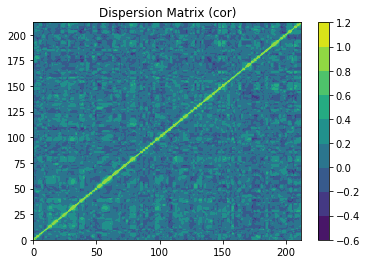

In [14]:
plt.contourf(R)
plt.colorbar()
title = 'Dispersion Matrix (' + dispmat + ')'
plt.title(title)

### Explained Variance

In [15]:
# Calculate the percent explained var by each eigenvector
pctvar = pct_variance(evals)

# Number of EOFs that explain more than 1% of the total variance
idx = pctvar[pctvar >= 1.0]
neofs = len(idx)

# print exp var >= 1.0
cumvar = np.sum(pctvar[0:neofs-1])
print(f'Cumulative variance explained by the first {neofs} EOFs:')
print(f'{cumvar:.2f}% \n')

# print exp var: neofs = 4
cumvar = np.sum(pctvar[0:3])
print(f'Cumulative variance explained by the first 4 EOFs:')
print(f'{cumvar:.2f}% \n')

# print exp var for 4 eofs
for k in range(4):
    print(f'{k+1} \t {pctvar[k]:.2f}%')

Cumulative variance explained by the first 23 EOFs:
66.08% 

Cumulative variance explained by the first 4 EOFs:
22.94% 

1 	 8.98%
2 	 8.72%
3 	 5.25%
4 	 4.70%


### North Test

In [16]:
err = north_test(evals, total_events)
upper = pctvar + err
lower = pctvar - err

print(np.round(upper[0:6],3))
print(np.round(pctvar[0:6],3))
print(np.round(lower[0:6],3))

[9.843 9.558 5.751 5.155 4.598 4.354]
[8.977 8.717 5.245 4.702 4.194 3.971]
[8.111 7.876 4.739 4.248 3.789 3.588]


### Fig 2: Variance

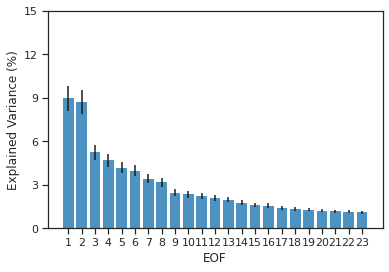

In [17]:
# set seaborn style
sns.set()
sns.set_style("ticks", {'patch.force_edgecolor':False})

# create figure
fig, ax = plt.subplots(figsize=(6,4))

# plot data
xvals = np.arange(neofs) + 1
ax.bar(xvals, pctvar[0:neofs], yerr=err[0:neofs], 
       color='tab:blue', alpha=0.8)

# x-axis
ax.set_xlabel('EOF')
ax.set_xticks(xvals)

# y-axis
ax.set_ylabel('Explained Variance (%)')
yticks = np.arange(0,16,3)
ax.set_yticks(yticks)
ax.set_yticklabels(yticks) 

# save fig
filepath = path_to_figs + 'exp_variance_' + fname_id + '.png'
plt.savefig(filepath, dpi=300)

# show
plt.show()

### Loadings

In [18]:
neofs = 19
loads = loadings(evals, evecs, neofs)

print(loads.shape)
print(np.round(loads,3))

(213, 19)
[[ 0.212 -0.269 -0.052 ...  0.065 -0.074 -0.282]
 [ 0.209 -0.04  -0.079 ... -0.168 -0.041 -0.126]
 [ 0.272 -0.391 -0.053 ... -0.148 -0.106 -0.033]
 ...
 [ 0.523  0.137 -0.025 ...  0.06   0.056 -0.051]
 [ 0.501  0.286  0.051 ... -0.075 -0.072 -0.113]
 [ 0.398  0.343  0.038 ... -0.152 -0.026  0.009]]


### Save EOFs

In [19]:
# Save eigenvalues, eigenvectors, and loadings

neofs = 4   # number of EOFs to save (evecs, loadings3)

outfile = path_to_out + 'eigenvalues_'+ fname_id + '.txt'
np.savetxt(outfile, evals, fmt='%.5f')

outfile = path_to_out + 'eigenvectors_'+ fname_id + '.txt'
np.savetxt(outfile, evecs[:,0:neofs], fmt='%.5f', delimiter=',')

outfile = path_to_out + 'loadings_'+ fname_id + '.txt'
np.savetxt(outfile, loads[:,0:neofs], fmt='%.4f', delimiter=',')


### PCs

In [20]:
# Calculate principal components (spatial modes)
neofs = 19
pcs = calc_pcs(Xs_wnan, evecs, neofs, mode=eofmode)

In [21]:
# Split pcs into separate arrays for each variable
ntim, nlat, nlon = var2.shape
npts = nlat*nlon
nvar = len(var_list)
# Reshape spatial dim back to 2D map
pcmodes = var_list
for i in np.arange(len(var_list)):
    tmp = pcs[:,i*npts:(i+1)*npts]
    pcmodes[i] = np.reshape(tmp, (neofs,nlat,nlon))

### Fig 3: Spatial Modes

In [22]:
# Panel Plot of Spatial Modes

# number of eofs to plot
neofs = 4

# Data for plotting extratropics
lons_et = var2.lon.data
lats_et = var2.lat.data
udat_et = pcmodes[0][0:neofs,:,:]
vdat_et = pcmodes[1][0:neofs,:,:]
data_et = pcmodes[2][0:neofs,:,:]

# Data for plotting tropics
lons_t = var4.lon.data
lats_t = var4.lat.data
udat_t = pcmodes[3][0:neofs,:,:]
vdat_t = pcmodes[4][0:neofs,:,:]
data_t = pcmodes[5][0:neofs,:,:]

print(np.nanmin(data_et), np.nanmax(data_et))
print(np.nanmin(data_t), np.nanmax(data_t))

# Set up projection
mapcrs = ccrs.PlateCarree()
datacrs = ccrs.PlateCarree()

# Set tick/grid locations
dx = np.arange(lonmin,lonmax+20,20)
dy = np.arange(latmin,latmax+20,20)

# subtitles
eof_label = [ ]
pc_label = [ ]
var_label = [ ]
for k in range(neofs):
    eof_label.append("EOF{:1d}".format(k+1,))
    pc_label.append("PC{:1d}".format(k+1,))
    var_label.append("{:.2f}%".format(pctvar[k]))

-0.0012832221429518028 0.504103215537983
-32.93853240680438 28.612767147735195


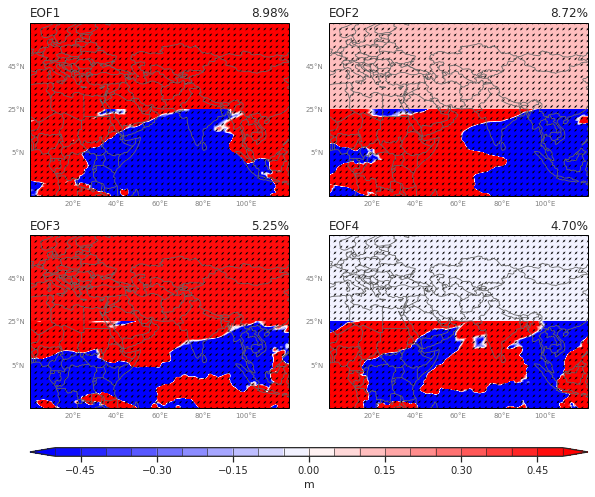

In [23]:
# Create figure
fig = plt.figure(figsize=(10,11))
filepath = path_to_figs + 'eofs_'+ fname_id + '.png'
nrows = 2
ncols = 2
# sns.set_style('ticks')

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 
                111, 
                axes_class=axes_class,
                nrows_ncols=(nrows, ncols), 
                axes_pad = 0.55,
                cbar_location='bottom', 
                cbar_mode='single',
                cbar_pad=0.0, 
                cbar_size='2.5%',
                label_mode='')

#newcmap = cmocean.tools.crop_by_percent(cmo.matter, 15, which='max', N=None)

# Loop for drawing each plot
for k, ax in enumerate(axgr):
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy)
#     ax = draw_basemap(ax, extent=None, xticks=dx, yticks=dy)
    
    # Add contour fill plot for extratropics
    clevs = np.arange(-0.5,0.55,.05)
    cf = ax.contourf(lons_et, lats_et, data_et[k,:,:], transform=datacrs,
                     levels=clevs,
                     cmap="bwr", extend='both')
    # add vectors for extratropics
    ax.quiver(lons_et, lats_et, udat_et[k,:,:], vdat_et[k,:,:], transform=datacrs,
              color='black', pivot='middle', regrid_shape=30) 
    
    # Add contour fill plot for q500
    cf = ax.contourf(lons_t, lats_t, data_t[k,:,:], transform=datacrs,
                     levels=clevs,
                     cmap="bwr", extend='both')
    # add vectors for tropics
    ax.quiver(lons_t, lats_t, udat_t[k,:,:], vdat_t[k,:,:], transform=datacrs,
              color='black', pivot='middle', regrid_shape=30)
    
    # subtitles
    ax.set_title(eof_label[k], loc='left', fontsize=12)
    ax.set_title(var_label[k], loc='right', fontsize=12)
    
# single colorbar
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True)
cb.set_label('m', fontsize=11)
cb.ax.tick_params(labelsize=10)
    
# Display figure
plt.savefig(filepath, dpi=200, bbox_inches='tight')
plt.show()

/home/nash/DATA/repositories/AR_types/figs/pc_HUVQ500t0120-1565cor.png


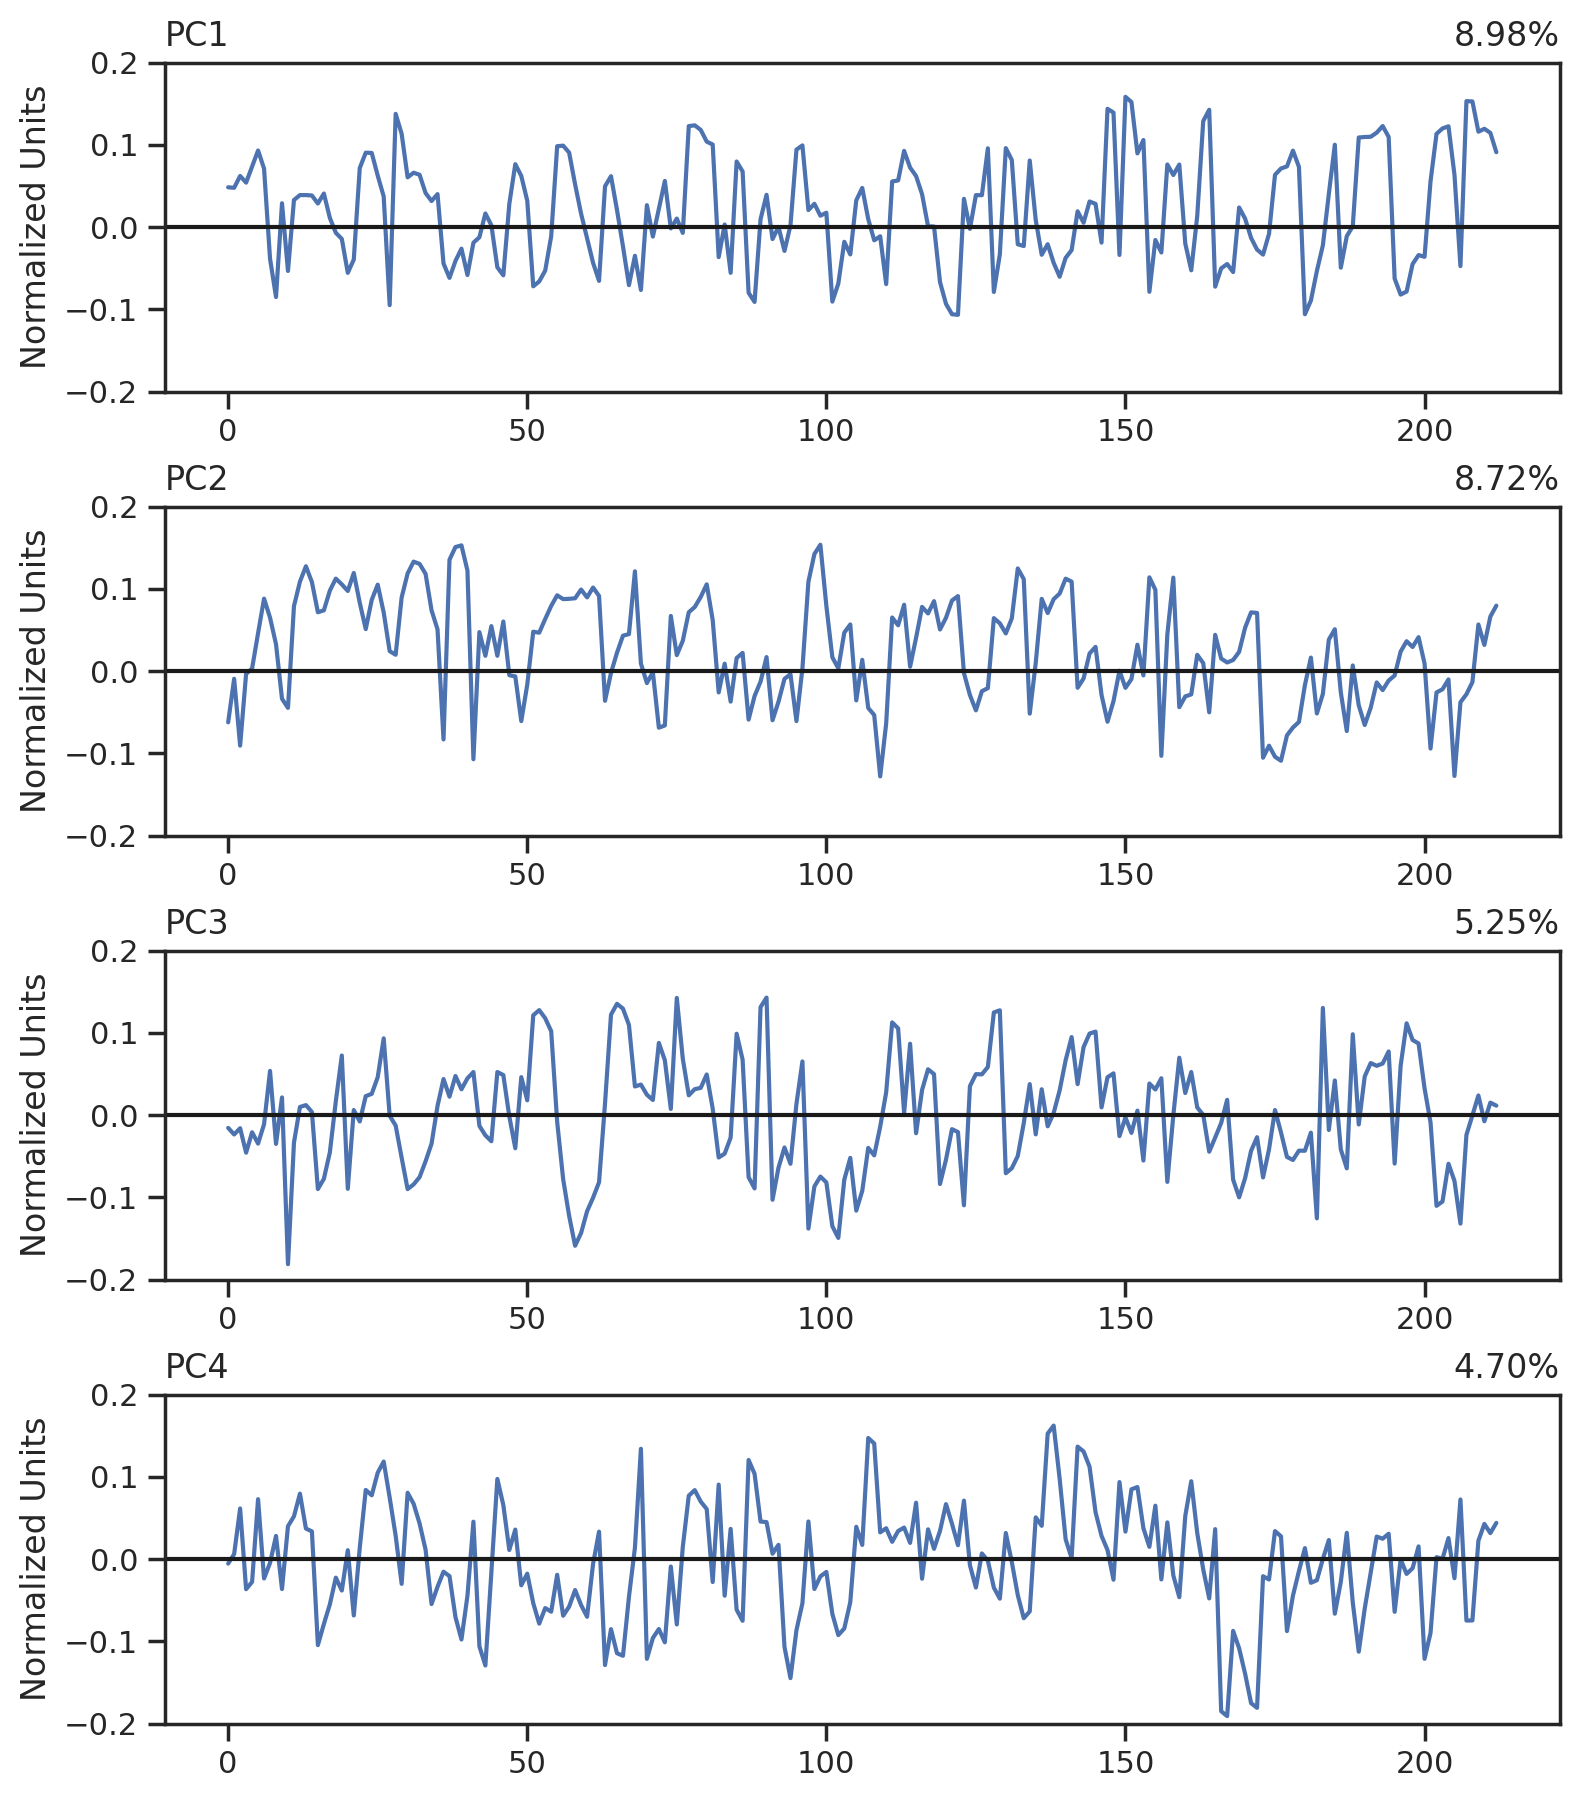

<Figure size 1800x2200 with 0 Axes>

In [24]:
fig = plt.figure(figsize=(9,11))
fig.dpi = 200
fname = path_to_figs + 'pc_'+ fname_id
fmt = 'png'
results = evecs[:,:4]

X, nplots = results.shape
x = np.arange(len(results))

for i in np.arange(nplots):
    ax = plt.subplot(4, 1, i+1)
    ax.plot(x, results[:,i], '-')
    ax.axhline(0, color='k')
    ax.set_ylim(-0.2, 0.2)
    ax.set_ylabel('Normalized Units')
    # subtitles
    ax.set_title(pc_label[i], loc='left', fontsize=12)
    ax.set_title(var_label[i], loc='right', fontsize=12)

plt.subplots_adjust(hspace=0.35, wspace=0.003)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi)
fig.clf()


plotFile = fname + '.png'
print(plotFile)
display(Image(plotFile))